In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:

ROOT = "."
OUT_DIR = osp.join(ROOT, "images-output")
SHUFFLE_DIR = osp.join(ROOT, "shuffle_split_dict.pt")
NUMATOMS_DIR = osp.join(ROOT, "num_atoms_split_dict.pt")
os.makedirs(OUT_DIR, exist_ok=True)

def save_im(name, fig=plt.gcf()):
    plt.savefig(osp.join(OUT_DIR, name + ".png"), dpi=600)
    plt.savefig(osp.join(OUT_DIR, name + ".svg"), dpi=600)

<Figure size 432x288 with 0 Axes>

In [3]:
# df_geo = pd.read_csv("pcqm4m-v2-geometry.csv.gz", nrows=None)
df_geo_norm = pd.read_csv("pcqm4m-v2-geometry.csv.gz", nrows=None)
num_cols = df_geo_norm.select_dtypes(include=np.floating).columns

In [4]:
num_atoms_split = torch.load(NUMATOMS_DIR)
shuffle_split = torch.load(SHUFFLE_DIR)

In [5]:
df_geo_norm[num_cols].std()

homolumogap          1.161870
Inertia_mass_a       0.569045
Inertia_mass_b       0.554145
Inertia_mass_c       0.138011
Inertia_valence_a    0.929480
Inertia_valence_b    0.869192
Inertia_valence_c    0.246078
length_a             0.174901
length_b             0.100739
length_c             0.095678
Spherocity           0.119631
Plane_best_fit       0.210412
dtype: float64

In [6]:
grouped_cols = {}
for col in num_cols:
    if (col.endswith("_a")) or (col.endswith("_b")) or (col.endswith("_c")):
        group_col = col[:-2]
    else:
        group_col = "other"
    if group_col in grouped_cols.keys():
        grouped_cols[group_col].append(col)
    else:
        grouped_cols[group_col] = [col]
grouped_cols

{'other': ['homolumogap', 'Spherocity', 'Plane_best_fit'],
 'Inertia_mass': ['Inertia_mass_a', 'Inertia_mass_b', 'Inertia_mass_c'],
 'Inertia_valence': ['Inertia_valence_a',
  'Inertia_valence_b',
  'Inertia_valence_c'],
 'length': ['length_a', 'length_b', 'length_c']}

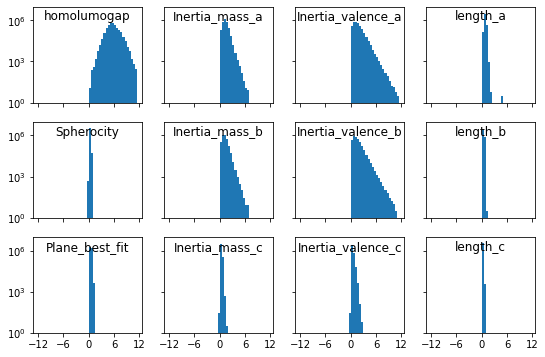

In [7]:
sz = 2
tick_max=12
ymax = 10**(np.ceil(np.log10(len(df_geo_norm))))
width = len(grouped_cols)
height = max([len(group_val) for group_val in grouped_cols.values()])
this_fig = plt.figure(figsize=(sz*width+1, sz*height))
for ii, (group_key, group_val) in enumerate(grouped_cols.items()):
    for jj, col in enumerate(group_val):
        ax = plt.subplot(height, width, width*(jj) + ii+1)
        ax.hist(df_geo_norm[col], log=True, bins=np.arange(-tick_max, tick_max, 0.5))
        ax.set_title(col, x=0.5, y=0.8)
        ax.set_ylim(1, ymax)
        if ii > 0:
            ax.set_yticklabels([])
        ax.set_xticks([-tick_max, -tick_max/2, 0, tick_max/2, tick_max])
        if jj < (height-1):
            ax.set_xticklabels([])
save_im("Distributions_not_normed")

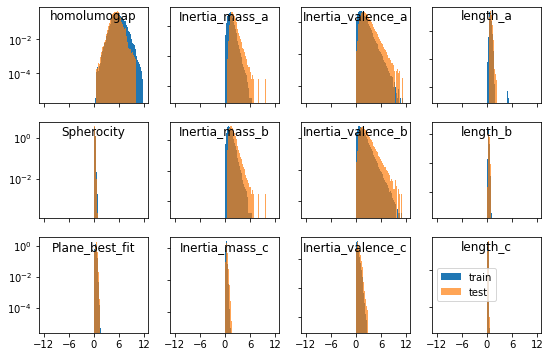

In [8]:
sz = 2
num_atoms_train_test = {"train": num_atoms_split["train"], "test": num_atoms_split["test"]}
tick_max=12
ymax = 10**(np.ceil(np.log10(len(df_geo_norm))))
width = len(grouped_cols)
height = max([len(group_val) for group_val in grouped_cols.values()])
this_fig = plt.figure(figsize=(sz*width+1, sz*height))
for ii, (group_key, group_val) in enumerate(grouped_cols.items()):
    for jj, col in enumerate(group_val):
        ax = plt.subplot(height, width, width*(jj) + ii+1)
        min_len = min([len(idx) for idx in num_atoms_split.values()])
        
        for kk, idx in enumerate(num_atoms_train_test.values()):
            ax.hist(df_geo_norm[col][idx], density=True, log=True, bins=np.arange(-tick_max, tick_max, 0.2), alpha=1-(kk*.3))
        ax.set_title(col, x=0.5, y=0.8)
        # ax.set_ylim(1, ymax)
        if ii > 0:
            ax.set_yticklabels([])
        ax.set_xticks([-tick_max, -tick_max/2, 0, tick_max/2, tick_max])
        if jj < (height-1):
            ax.set_xticklabels([])
plt.legend(num_atoms_train_test.keys(), loc="center left")
save_im("Distributions_not_normed_densities_train_test")

In [9]:
def float_to_str(val):
    if isinstance(val, pd.Series):
        val = val.apply(float_to_str)
    else:
        if np.abs(val) <= 1 + 1e-3:
            val = f"{val:.2f}"
            val = val.replace("1.00", "1.")
        else:
            val = f"{val:.1f}"
        val = val.replace("0.", ".")
    return val

In [10]:
def correlation_plot(df, corr_fn, max_samples=200000, vmax=1, vmin=-1, cmap="PiYG", title=""):
    n_samples = min(len(df), max_samples)
    corr = df.sample(n=n_samples).corr(corr_fn)
    annot = corr.apply(float_to_str)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    plt.title(title, y=0.85)
    ax = sns.heatmap(corr, cmap=cmap, annot=annot.values, vmax=vmax, vmin=vmin, fmt="", square=True, mask=mask,
        cbar_kws={"orientation": "horizontal", "location": "top"})

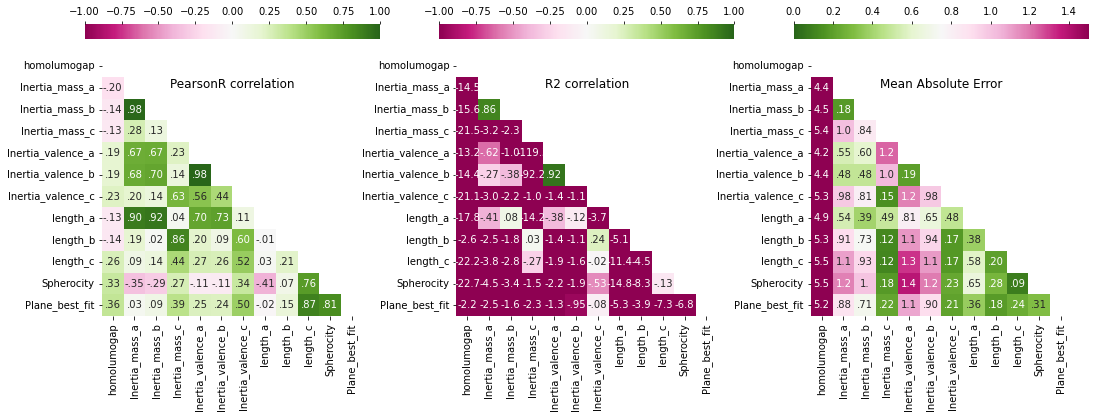

In [11]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
correlation_plot(df_geo_norm, corr_fn="pearson", title="PearsonR correlation")

plt.subplot(1, 3, 2)
correlation_plot(df_geo_norm, corr_fn=r2_score, title="R2 correlation")

plt.subplot(1, 3, 3)
correlation_plot(df_geo_norm, corr_fn=mean_absolute_error, title="Mean Absolute Error", vmax=1.5, vmin=0, cmap="PiYG_r")

save_im("Correlations_all_not_normed")


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(num_cols))
pca.fit(df_geo_norm[num_cols].sample(n=10000))

PCA(n_components=12)

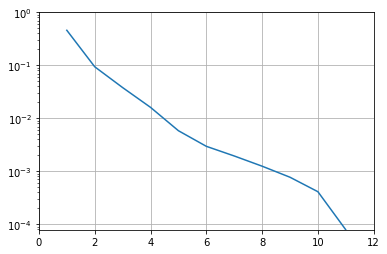

In [13]:
exp_var = 1-np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(num_cols))+1, exp_var)
plt.ylim(min(exp_var[:-1]), 1)
plt.xlim(0, len(num_cols))
# plt.hlines([.7, .9, .95, .975], xmin=0, xmax=len(num_cols), linestyles=":")
plt.grid()
plt.yscale("log", base=10)